## Vocalization Classifier for Macaque 'coo' calls.

**Aim** : This project aims to demonstrate the efficacy of using fastai's easy to use software library to build deep learning models for seemingly complex problems.

![macaque](images/macaque.jpg)

**Summary** : The project builds a deep learning model to classify the distinct 'coo' calls or vocalizations of eight distinct macaques. The vocalizations are stored in the 'wav' format, however the classification process is done on the spectograms (images). This allows me to train a powerful ImageNet model - resnet34 - for a seemingly unrelated problem, that of sound classification.

The dataset used in this project is available here : https://datadryad.org/stash/dataset/doi:10.5061/dryad.7f4p9

The study that was conducted on this dataset can be found here : https://royalsocietypublishing.org/doi/10.1098/rsos.150432

The table (taken from the study) below, lists the eight monkeys using a two-letter alphabetical code, which was also used in this project.

![table](images/table.JPG)

This study used a linear classifier to achieve a final 'mean classification performance' of 92%.

**Result** : This model is able to achieve around 97-98% classification accuracy on the validation set with nearly equal training and validation losses, beating the linear classifier used in the study handily. 





### Jupyter Notebook magic commands.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Libraries used in the project.

In [1]:
from fastai.vision import *
from fastai import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import numpy as np
import librosa.display

Since this project was executed on a local environment with a powerful GPU, the path structure is accordingly adjusted.

In [2]:
path = Path('sounds')

### Generating Spectograms.

The following function allows the conversion of the 'wav' sound files to 'png' spectograms (images). 
The function takes the foldername containing the 'wav' files as input and generates spectograms in a separate folder called 'specto'.  
The librosa package is used here.  
The code is inspired by this project, found here : https://github.com/etown/dl1/blob/master/UrbanSoundClassification.ipynb

In [16]:
def create_fold_spectrograms(folder):
    spectrogram_path = Path('specto')  
    audio_path = path  
    os.makedirs(spectrogram_path/folder,exist_ok=True)
    for audio_file in list(Path(audio_path/f'{folder}').glob('*.wav')):
        samples, sample_rate = librosa.load(audio_file)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        filename  = spectrogram_path/folder/Path(audio_file).name.replace('.wav','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

In [17]:
sounds=['AL','BE','IO','MU','QU','SN','TH','TW']

In [18]:
for i in sounds:
  create_fold_spectrograms(str(i))

### Creating the Data Bunch.

After converting the sound files to spectograms, the dataset of images is converted to a data bunch consisting of a training and validation set.

Unlike standard image classification problems, no image transformations are applied here as that can result in the spectogram representing something completely different. 

In [2]:
sp_path = 'specto'
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(sp_path, train=".", ds_tfms=tfms, valid_pct=0.2, size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5828 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
AL,AL,AL,AL,AL
Path: specto;

Valid: LabelList (1457 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
MU,IO,TH,IO,TH
Path: specto;

Test: None

The code below displays nine random spectograms along with their labels.

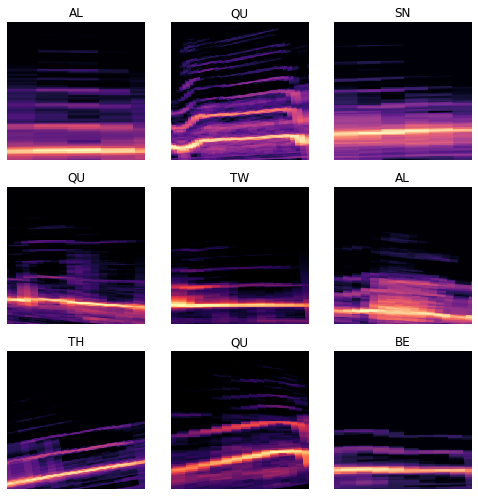

In [3]:
data.show_batch(rows=3,figsize=(7,7))

### The Data Bunch at a glance.

Below we see the eight classes of macaque that we will use the model to classify on, along with a good split between the Training and Validation set containing 5828 and 1457 images respectively

In [4]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['AL', 'BE', 'IO', 'MU', 'QU', 'SN', 'TH', 'TW'], 8, 5828, 1457)

### Training the model.

The learner is initialized below with the powerful resnet34 ImageNet model.
The idea is to train on the last two layers of this pre-built model until we can achieve a suitable accuracy, training loss and validation loss.

In [5]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy])

Over several experiments with random seeds and different compositions of the training and validation sets, I settled on training the model for around 24-30 epochs to achieve nearly equal training and validation losses (a good enough result). This was to ensure that the model does not overfit.

In [6]:
learn.fit_one_cycle(24)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.663456,0.778601,0.255319,0.744681,01:49
1,0.958558,0.421619,0.139327,0.860673,01:48
2,0.668959,0.367270,0.121482,0.878518,01:48
3,0.533899,0.265337,0.079616,0.920384,01:41
4,0.432331,0.256022,0.084420,0.915580,01:40
5,0.371432,0.204039,0.072066,0.927934,01:40
6,0.310795,0.224151,0.072066,0.927934,01:41
7,0.286729,0.165861,0.056966,0.943034,01:41
8,0.239920,0.162528,0.048044,0.951956,01:41
9,0.208234,0.133992,0.039808,0.960192,01:43


This is a good enough result. The model built so far is saved.

In [7]:
learn.save('stage-1', return_path=True)

WindowsPath('specto/models/stage-1.pth')

### Optimum Learning Rate.

Now, I unfreeze all layers of the model and find an optimum learning rate to train on.

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


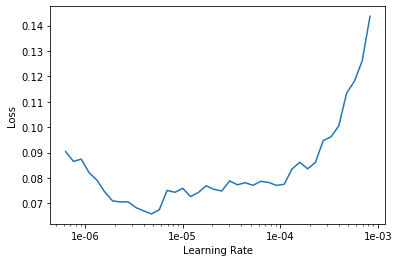

In [9]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

By visually inspecting the graph, the optimum learning rate appears to be between 1e-06 and 5e-06. The model is trained again for two sets of two epochs using this range of learning rates.

In [10]:
learn.fit_one_cycle(2, max_lr=slice(1e-06,5e-06))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.090581,0.079203,0.025395,0.974605,01:52
1,0.080452,0.075230,0.023336,0.976664,01:54


In [11]:
learn.fit_one_cycle(2, max_lr=slice(1e-06,5e-06))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.076831,0.073346,0.024708,0.975292,01:55
1,0.079206,0.072435,0.022649,0.977351,01:55


The training loss and validation loss are nearly similar. Progress is saved again.

In [12]:
learn.save('stage-2', return_path=True)

WindowsPath('specto/models/stage-2.pth')

### Confusion Matrix.


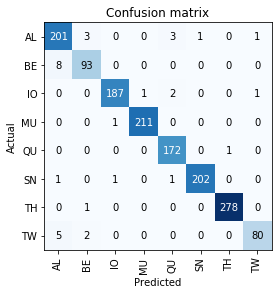

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The performance of the model can be gauged using the confusion matrix above.  
It appears that the model classified 'BE' wrong the most, eight times, followed by 'TW', five times.  

### Top losses.

Below are the nine data points with the highest losses.

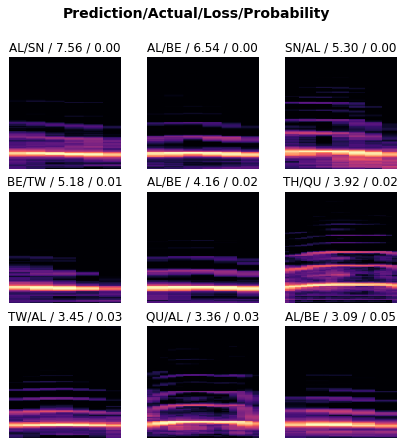

In [14]:
interp.plot_top_losses(9, figsize=(7,7))